## Import Statements

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from adjustText import adjust_text
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse


## Analysis Helper Functions
This is the new part of the analysis.

In [2]:
def get_data_file_path(current_trial_name="v1_eval", base_folder="game_logs", trial_base_name="alfworld_eval_", csv_file_name="alfworld_results.csv"):
    """returns the csv file path."""
    current_trial_folder = trial_base_name + current_trial_name
    file_path = os.path.join(base_folder, current_trial_folder, csv_file_name)
    return file_path
    
def convert_string_to_bool(in_string):
    """if string ="" False, else True"""
    if in_string:
        return True
    else:
        return False

def convert_string_to_bool_int(in_string):
    """if string ="" False, else True"""
    if in_string:
        return 1
    else:
        return 0

def convert_bool_string_to_bool_int(in_string):
    """ if string==False -> False, etc."""
    if in_string=="(False,)" or in_string=="False":
        return 0
    elif in_string=="(True,)" or in_string=="True":
        return 1
    elif in_string=="0":
        return 0
    elif in_string=="1":
        return 1
    else:
        print(type(in_string))
        print(in_string)
        print(in_string[0])
        raise Exception("Error in Transforming BoolString to Int")

In [3]:
def load_data(trial_name, file_path=None):
    if file_path == None:
        file_path=os.path.join("game_logs",f"alfworld_eval_{trial_name}","alfworld_results.csv")
    df = pd.read_csv(
        file_path, 
        quoting=1,
        index_col=False, 
        converters = {
            "early_stop":convert_string_to_bool_int, 
            "error": convert_string_to_bool_int
        }
    )
    return df

In [4]:
def analyse_data(input_data, total_envs: int = 134):
    """
    Returns:
        x     – DataFrame grouped by prompt_name **with a new 'failures' column**
        out2  – Flat table incl. success/fail + efficiency features:
                tokens_per_step, avg_history_token, efficiency_success_per_1k_tok
        success_df – Per-model per-task success table
    """
    # ------------------------------------------------------------------ #
    # Aggregate per model / prompt / correction (explicit agg to keep needed sums)
    # ------------------------------------------------------------------ #
    agg = (
        input_data
        .groupby(["model", "prompt_name", "correction"], as_index=False)
        .agg(
            success=("success", "sum"),
            total=("success", "count"),
            done=("done", "sum"),
            early_stop=("early_stop", "count"),  # placeholder; you can refine if needed
            error=("error", "count"),            # placeholder; you can refine if needed
            num_of_steps=("num_of_steps", "sum"),

            # token sums across episode runs
            total_prompt_token=("total_prompt_token", "sum"),
            total_in_token_accumulated=("total_in_token_accumulated", "sum"),
            total_in_token_message_accumulated=("total_in_token_message_accumulated", "sum"),
            total_out_token_accumulated=("total_out_token_accumulated", "sum"),
            total_history_token=("total_history_token", "sum"),
        )
    )

    # Compute failures and success %
    agg["failures"] = agg["total"] - agg["success"]
    agg["success_percentage"] = agg["success"] / total_envs * 100.0

    # Efficiency-related totals
    agg["total_io_tokens"] = (
        agg["total_in_token_accumulated"] + agg["total_out_token_accumulated"]
    )

    # Tokens per step (guard against zero division)
    agg["tokens_per_step"] = agg["total_io_tokens"] / agg["num_of_steps"].replace(0, np.nan)

    # Average history length at the end of an episode (mean across runs)
    agg["avg_history_token"] = agg["total_history_token"] / agg["total"].replace(0, np.nan)

    # Efficiency metric: successes per 1k total tokens
    # (how many successful episodes you got per 1,000 tokens spent)
    denom_k = (agg["total_io_tokens"] / 10000).replace(0, np.nan)
    agg["efficiency_success_per_10k_tok"] = agg["success"] / denom_k
    
    agg["total_io_tokens"] = agg["total_io_tokens"] / agg["total"]

    # ------------------------------------------------------------------ #
    # Average steps (overall / conditioned on success or failure) by model
    # ------------------------------------------------------------------ #
    avg_suc_steps, avg_fail_steps, avg_steps = [], [], []
    success_table = []

    for model in input_data.model.unique():
        model_data = input_data[input_data["model"] == model]

        avg_suc_steps.append(model_data[model_data["success"] == True]["num_of_steps"].mean())
        avg_fail_steps.append(model_data[model_data["success"] == False]["num_of_steps"].mean())
        avg_steps.append(model_data["num_of_steps"].mean())

        # Per-task success table for this model
        for task in sorted(model_data["env_type"].unique()):
            sub = model_data[model_data["env_type"] == task]
            total = len(sub)
            success = (sub["success"].sum() / total * 100) if total else 0.0
            success_table.append({
                "Model": model,
                "Task": task.capitalize(),
                "Success": f"{success:.2f}%",
            })

    success_df = pd.DataFrame(success_table)

    # Attach avg step stats once per-agg row by aligning on model
    model_stats = (
        pd.DataFrame({
            "model": input_data.model.unique(),
            "avg_success_steps": avg_suc_steps,
            "avg_fail_steps": avg_fail_steps,
            "avg_steps": avg_steps,
        })
    )
    agg = agg.merge(model_stats, on="model", how="left")

    # ------------------------------------------------------------------ #
    # Prepare `out` (keeps your legacy columns) and `x`
    # ------------------------------------------------------------------ #
    out_header_order = [
        "model", "prompt_name", "correction",
        # legacy metrics
        "success", "failures", "done", "num_of_steps",
        # percentages / averages you were already returning
        "success_percentage", "avg_success_steps", "avg_fail_steps", "avg_steps",
        # new efficiency-related columns
        "total_io_tokens", "tokens_per_step", "avg_history_token", "efficiency_success_per_10k_tok",
    ]
    # Some legacy columns (env_idx, early_stop, error) were sums/counts above; include if you want:
    # out_header_order.extend(["early_stop", "error"])

    out = agg[out_header_order].copy()

    # Group object (by prompt_name) like before
    x = out.groupby("prompt_name")

    # Flat summary table (your former out2), now with the new metrics
    out2 = out[[
        "model", "prompt_name", "correction",
        "success_percentage", "success", "failures",
        "avg_success_steps", "avg_fail_steps", "avg_steps",
        "total_io_tokens", "tokens_per_step", "avg_history_token", "efficiency_success_per_10k_tok",
    ]].copy()

    return x, out2, success_df

In [5]:
def print_results(file_name, file_path=None):
    df = load_data(file_name, file_path)

    print(df.agent_type.unique())
    print(df.model.unique())
    print(f"\nResults for {file_name}")
    success_table = {}
    for model in df.model.unique():
        success_table[model] = []
        print(f"For Model: {model}")
        df_m = df[df.model == model]
        for agent in df.agent_type.unique():
            print(f"\nFor Agent: {agent}")
            df_t = df_m[df_m.agent_type == agent]
            print(f"Success: {df_t.success.mean()*100:.2f}")
            print(f"Avg. Steps: {df_t.num_of_steps.mean():.2f}")
            print(f"Avg. Tokens: {df_t.total_in_token_accumulated.mean() + df_t.total_out_token_accumulated.mean():.0f}")
            
            # Per-task success table for this model
            for task in sorted(df_t["env_type"].unique()):
                sub = df_t[df_t["env_type"] == task]
                total = len(sub)
                success = (sub["success"].sum() / total * 100) if total else 0.0
                success_table[model].append({
                    "Agent": agent,
                    "Task": task.capitalize(),
                    "Success": f"{success:.2f}%",
                })
            print(f"Successes: {len(df_t[df_t.success==1])}, Fails: {len(df_t[df_t.success==0])}")
    
        print(pd.DataFrame(success_table[model]))

In [126]:
def print_per_category(df):
    print("*"*30)
    for category in df.category.unique():
        sub_df = df[df.category == category]
        sub_total_success = len(sub_df[sub_df["total_reward"]==1])/len(sub_df)*100
        print(f"{len(sub_df)} {category:<15}: {sub_total_success:.2f} | {sub_df.total_reward.mean():.4f}")

def load_run_df(file_root, run_name):
    p = Path(file_root) / run_name / "alfworld_results.csv"
    return pd.read_csv(p)

def summarize_run(df):
    """Compute metrics used for efficiency comparisons."""
    success_rate = (df["total_reward"] == 1).mean()  # fraction of perfect episodes
    avg_reward   = df["total_reward"].mean()
    avg_steps    = df["num_of_steps"].mean()
    avg_tokens   = (df["total_in_token_accumulated"] + df["total_out_token_accumulated"]).mean()
    eff_per_1k   = success_rate / (avg_tokens / 1000.0) if avg_tokens > 0 else float("nan")
    return {
        "success_rate": success_rate,         # 0..1
        "avg_reward": avg_reward,             # 0..1 (WebShop score in [0,1])
        "avg_steps": avg_steps,
        "avg_tokens": avg_tokens,             # raw tokens
        "success_per_1k_tokens": eff_per_1k,  # success per 1k tokens
        "n": len(df),
    }

def collect_metrics(file_root, run_names):
    rows = []
    for name in run_names:
        df = load_run_df(file_root, name)
        # print(df)
        m = summarize_run(df)
        try:
            filtered_name = name.split('/', 1)[1]
        except:
            filtered_name = name
        m["run"] = filtered_name
        rows.append(m)
    return pd.DataFrame(rows)


def _draw_ellipse_cluster(ax, xs, ys, color, alpha=0.12, lw=2, linestyle="--", scale=1.0, min_width=0.5, min_height=5.0):
    """
    Draw a covariance-based ellipse around (xs, ys).
    Works for n >= 2. 'scale' ~2.5 ≈ 95% region for Gaussian-ish blobs.
    min_width/min_height ensure the ellipse isn't collapsed into a line.
    """
    xs = np.asarray(xs); ys = np.asarray(ys)
    if len(xs) < 2:
        return  # still need at least 2 points to draw something meaningful

    X = np.vstack([xs, ys])
    cov = np.cov(X)  # 2x2
    cov += np.eye(2) * 1e-3

    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # width/height of the ellipse (2 * scale * std)
    width, height = 2 * scale * np.sqrt(vals[0]), 0.5* scale * np.sqrt(vals[1])

    # enforce a minimum width/height so it looks like a region instead of a line
    width = max(width, min_width)
    height = max(height, min_height)

    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    center = (xs.mean(), ys.mean())

    e = Ellipse(xy=center, width=width, height=height, angle=angle,
                facecolor=color, edgecolor=color, lw=lw, linestyle=linestyle, alpha=alpha)
    ax.add_patch(e)



def plot_success_vs_tokens(metrics_df, title="Efficiency: Success vs. Tokens (lower x is better)", 
                           font_size=11, save=False):
    # x: tokens (in K); y: score (%)
    x = (metrics_df["avg_tokens"] / 1000.0).to_numpy()
    y = (metrics_df["success_rate"] * 100.0).to_numpy()
    labels = metrics_df["run"].tolist()

    # fig, ax = plt.subplots(figsize=(7, 6.5))
    fig, ax = plt.subplots(figsize=(5.5, 5))
    texts = []
    scatters = []
    # collect points per variant for cluster ellipses
    groups = {"base": {"x": [], "y": []},
              "rag": {"x": [], "y": []},
              "ft": {"x": [], "y": []},
              "ft_rag": {"x": [], "y": []}}

    for xi, yi, lab in zip(x, y, labels):
        if "ft_rag" in lab:
            variant = "ft_rag"
        elif "ft" in lab:
            variant = "ft"
        elif "rag" in lab:
            variant = "rag"
        else:
            variant = "base"

        c = color_map[variant]
        pretty_label = label_map.get(lab, lab)

        s = ax.scatter(xi, yi, color=c, s=80, edgecolor="black", linewidth=0.6)
        texts.append(ax.text(xi, yi, pretty_label, fontsize=font_size))
        scatters.append(s)  # collect scatter handle
        groups[variant]["x"].append(xi)
        groups[variant]["y"].append(yi)

    # draw ellipses per variant (works for n >= 2)
    for variant, pts in groups.items():
        if len(pts["x"]) >= 2:
            _draw_ellipse_cluster(ax, pts["x"], pts["y"], color=color_map[variant])

    # de-overlap labels
    adjust_text(texts, 
                # add_objects=scatters, 
                expand=(1, 3),
                arrowprops=dict(arrowstyle="->", color="black", lw=0.2),
                lim=1000,                                   # more iterations if needed
               )

    ax.set_xlabel("Average tokens per episode ($10^3$)")
    ax.set_ylabel("Success Rate (%)", fontsize=font_size+1)
    ax.set_title(title, fontsize=font_size+2)
    ax.grid(True, linestyle=":", linewidth=0.8)

    # legend (variants)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Base',
               markerfacecolor=color_map["base"], markersize=10, markeredgecolor="black"),
        Line2D([0], [0], marker='o', color='w', label='RAG',
               markerfacecolor=color_map["rag"], markersize=10, markeredgecolor="black"),
        Line2D([0], [0], marker='o', color='w', label='SFT',
               markerfacecolor=color_map["ft"], markersize=10, markeredgecolor="black"),
        Line2D([0], [0], marker='o', color='w', label='Distillation',
               markerfacecolor=color_map["ft_rag"], markersize=10, markeredgecolor="black"),
    ]
    ax.legend(handles=legend_elements, title="Variants", fontsize=font_size, title_fontsize=font_size+1)

    plt.tight_layout()
    if save:
        plt.savefig("test.png", dpi=400)
    plt.show()
    
def print_metrics_table(metrics_df):
    # Nicely formatted console summary
    cols = ["run", "n",
            "success_rate", "avg_steps",
            "avg_tokens", "success_per_1k_tokens"]
    dfp = metrics_df[cols].copy()
    dfp["success_rate"] = (dfp["success_rate"] * 100).map(lambda v: f"{v:.2f}")
    dfp["avg_steps"] = dfp["avg_steps"].map(lambda v: f"{v:.2f}")
    dfp["avg_tokens"] = (dfp["avg_tokens"] / 1000.0).map(lambda v: f"{v:.2f}k")
    dfp["success_per_1k_tokens"] = dfp["success_per_1k_tokens"].map(lambda v: f"{v:.3f}")
    print("\n=== Efficiency Summary ===")
    print(dfp.to_string(index=False))
    
label_map = {
    "react": "ReAct",
    "react_rag": "ReAct+RAG",
    "react_ft": "ReAct+SFT",
    "react_ft_rag": "ReAct+Distillation",
    "react_rag_ft": "ReAct+SFT+RAG",          
    "react_rag_ft_rag": "ReAct+Distillation+RAG", 
    "state": "State",
    "state_rag": "State+RAG",
    "state_ft": "State+SFT",
    "state_ft_rag": "State+Distillation",
    "state_rag_ft": "State+SFT+RAG",
    "state_rag_ft_rag": "State+Distillation+RAG",
}

# Color scheme: one for Act variants, one for State variants
color_map = {
    "base": "tab:blue",
    "rag": "tab:orange",
    "ft": "tab:green",
    "ft_rag": "tab:red",
}


=== Efficiency Summary ===
         run   n success_rate avg_steps avg_tokens success_per_1k_tokens
       react 134        77.61     23.19     47.72k                 0.016
   react_rag 134        79.10     24.01     54.81k                 0.014
    react_ft 134        86.57     25.39     54.98k                 0.016
react_ft_rag 134        92.54     19.37     38.12k                 0.024
       state 134        82.09     14.69     52.53k                 0.016
   state_rag 134        85.07     15.20     53.12k                 0.016
    state_ft 134        84.33     13.37     45.73k                 0.018
state_ft_rag 134        89.55     13.99     51.51k                 0.017


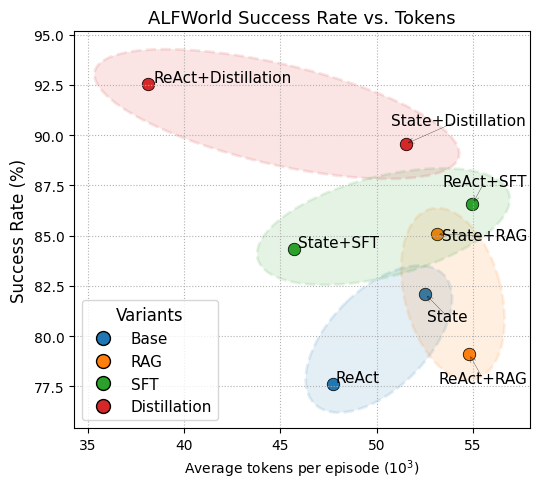

In [128]:
# Usage:
file_root = "game_logs"
run_names = [
    "baselines/react",
    "baselines/react_rag",
    "regular_sft/react_ft",
    "distilled_sft/react_ft_rag",
    "baselines/state",
    "baselines/state_rag",
    "regular_sft/state_ft",
    "distilled_sft/state_ft_rag"
]

metrics = collect_metrics(file_root, run_names)
print_metrics_table(metrics)
plot_success_vs_tokens(metrics, title="ALFWorld Success Rate vs. Tokens", font_size=11, save=True)

In [130]:
run_name = ["baselines/react_rag", "alfworld_eval_react_rag_sanity2"]

print_metrics_table(collect_metrics("game_logs", run_name))


=== Efficiency Summary ===
                            run   n success_rate avg_steps avg_tokens success_per_1k_tokens
                      react_rag 134        79.10     24.01     54.81k                 0.014
alfworld_eval_react_rag_sanity2 134        88.81     22.17     47.78k                 0.019


In [160]:
run_name = ["baselines/react_rag", "ablation/react_rag_bm25", "ablation/react_rag_tfidf",
           "baselines/state_rag", "ablation/state_rag_bm25", "ablation/state_rag_tfidf"]

print_metrics_table(collect_metrics("game_logs", run_name))


=== Efficiency Summary ===
            run   n success_rate avg_steps avg_tokens success_per_1k_tokens
      react_rag 134        79.10     24.01     54.81k                 0.014
 react_rag_bm25 134        79.85     20.34     43.60k                 0.018
react_rag_tfidf 134        79.85     20.34     43.60k                 0.018
      state_rag 134        85.07     15.20     53.12k                 0.016
 state_rag_bm25 134        85.82     15.07     54.08k                 0.016
state_rag_tfidf 134        85.82     15.07     54.08k                 0.016


In [156]:
run_name = ["ablation/react_rag_1hint", "baselines/react_rag", "ablation/react_rag_6hint", "ablation/react_rag_9hint",
           "ablation/state_rag_1hint", "baselines/state_rag", "ablation/state_rag_6hint", "ablation/state_rag_9hint"]

print_metrics_table(collect_metrics("game_logs", run_name))


=== Efficiency Summary ===
            run   n success_rate avg_steps avg_tokens success_per_1k_tokens
react_rag_1hint 134        81.34     22.70     49.53k                 0.016
      react_rag 134        79.10     24.01     54.81k                 0.014
react_rag_6hint 134        82.09     21.07     46.23k                 0.018
react_rag_9hint 134        78.36     20.53     45.30k                 0.017
state_rag_1hint 134        86.57     15.51     54.51k                 0.016
      state_rag 134        85.07     15.20     53.12k                 0.016
state_rag_6hint 134        86.57     15.19     55.66k                 0.016
state_rag_9hint 134        75.37     18.00     69.22k                 0.011


In [111]:
run_name = ["7B_results/react", "7B_results/react_rag", "7B_results/react_ft", "7B_results/react_ft_rag",
           "7B_results/state", "7B_results/state_rag", "7B_results/state_ft", "7B_results/state_ft_rag"]

print_metrics_table(collect_metrics("game_logs", run_name))


=== Efficiency Summary ===
         run   n success_rate avg_steps avg_tokens success_per_1k_tokens
       react 134        11.19     22.26     48.71k                 0.002
   react_rag 134        73.13     27.16     62.74k                 0.012
    react_ft 134        11.19     24.29     54.50k                 0.002
react_ft_rag 134        68.66     27.86     67.62k                 0.010
       state 134        41.79     16.09     55.80k                 0.007
   state_rag 134        69.40     16.90     64.06k                 0.011
    state_ft 134        75.37     13.47     43.03k                 0.018
state_ft_rag 134        79.10     14.52     48.06k                 0.016


In [154]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---- Config ----
file_root = "game_logs"
run_names = [
    "baselines/react",
    "baselines/react_rag",
    "regular_sft/react_ft",
    "distilled_sft/react_ft_rag",
    "baselines/state",
    "baselines/state_rag",
    "regular_sft/state_ft",
    "distilled_sft/state_ft_rag"
]
# run_names = ["baselines/react_rag", "ablation/react_rag_bm25", "ablation/react_rag_tfidf"]

run_names = ["ablation/react_rag_1hint", "baselines/react_rag", "ablation/react_rag_6hint", "ablation/react_rag_9hint",
           "ablation/state_rag_1hint", "baselines/state_rag", "ablation/state_rag_6hint", "ablation/state_rag_9hint"]

# Map the short run key -> (agent, method)
# short key is the part after the first '/'
key_map = {
    "react":            ("react", "Base"),
    "react_rag":        ("react", "RAG"),
    "react_rag_1hint":  ("react", "RAG-1"),
    "react_rag_6hint":  ("react", "RAG-6"),
    "react_rag_9hint":  ("react", "RAG-9"),
    "react_ft":         ("react", "SFT"),
    "react_ft_rag":     ("react", "Distillation"),
    "react_rag_bm25":   ("react", "RAG-BM25"),
    "react_rag_tfidf":  ("react", "RAG-TFIDF"),
    "state":            ("state", "Base"),
    "state_rag":        ("state", "RAG"),
    "state_rag_1hint":  ("state", "RAG-1"),
    "state_rag_6hint":  ("state", "RAG-6"),
    "state_rag_9hint":  ("state", "RAG-9"),
    "state_ft":         ("state", "SFT"),
    "state_ft_rag":     ("state", "Distillation"),
}

# Pretty order/labels for ALFWorld env types
type_display_map = {
    "clean": "Clean",
    "cool": "Cool",
    "examine": "Examine",
    "heat": "Heat",
    "put": "Put",
    "puttwo": "PutTwo",
}
type_order = ["Clean", "Cool", "Examine", "Heat", "Put", "PutTwo"]
method_order = ["Base", "RAG", "SFT", "Distillation"]

def load_run_df(root, run_path):
    p = Path(root) / run_path / "alfworld_results.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    return pd.read_csv(p)

def per_type_success(df):
    # success defined as total_reward == 1
    g = df.groupby("env_type").agg(
        n=("env_type", "size"),
        succ=("success", lambda s: (s == 1).sum())
    ).reset_index()
    g["succ_rate"] = (g["succ"] / g["n"]) * 100.0
    # normalize type names
    g["Type"] = g["env_type"].map(type_display_map).fillna(g["env_type"])
    return g[["Type", "n", "succ_rate"]]

# Collect per-type stats for each (agent, method)
stats = {}  # stats[(agent, method)] = DataFrame(Type, n, succ_rate)
print("\n==== Per-run per-type success (for sanity) ====")
for rp in run_names:
    short = rp.split("/", 1)[1]
    agent, method = key_map[short]
    df = load_run_df(file_root, rp)
    g = per_type_success(df)
    stats[(agent, method)] = g

    print(f"\n[{short}]")
    for _, r in g.sort_values("Type").iterrows():
        print(f"{r['Type']:<8}  n={int(r['n']):>4}  success={r['succ_rate']:.2f}%")
    s = "Mean"
    n = len(df)
    successes = df["success"].sum()/n*100
    print(f"{s:<8}  n={n:>4}  success={successes:.2f}%")
# Build the table: average across agents for each method, per Type
rows = []
for T in type_order:
    row = {"Type": T}
    for method in method_order:
        # fetch react + state rows for this type/method
        vals = []
        for agent in ["react", "state"]:
            g = stats.get((agent, method))
            if g is None:
                continue
            sub = g[g["Type"] == T]
            if not sub.empty:
                vals.append(float(sub["succ_rate"].iloc[0]))
        # average across available agents
        row[method] = np.mean(vals) if len(vals) else np.nan
    rows.append(row)

table_df = pd.DataFrame(rows).set_index("Type")

# Weighted "Mean" across all types & both agents for each method
def weighted_method_mean(method):
    total_succ = 0.0
    total_n = 0
    for agent in ["react", "state"]:
        g = stats.get((agent, method))
        if g is None:
            continue
        total_succ += (g["succ_rate"] / 100.0 * g["n"]).sum()
        total_n += g["n"].sum()
    return (total_succ / total_n) * 100.0 if total_n > 0 else np.nan

mean_row = {m: weighted_method_mean(m) for m in method_order}
table_df.loc["\\textbf{Mean}"] = [mean_row[m] for m in method_order]

# Print LaTeX table block
def to_latex_block(df):
    lines = []
    for idx in type_order + ["\\textbf{Mean}"]:
        if idx not in df.index:  # safety
            continue
        vals = [df.loc[idx, m] for m in method_order]
        vals_str = " & ".join(f"{v:.2f}" for v in vals)
        lines.append(f"    {idx:<8} & {vals_str} \\\\")
    body = "\n".join(lines)
    latex = rf"""
\begin table [H]
  \centering
  \caption{{Average of both agents' performance on ALFWorld, shown per category type, using a 14B backbone.}}
  \label{{tab:alfworld-pertype-compact}}
  \begin tabular {{lcccc}}
    \toprule
    \multicolumn{{1}}{{c}}{{\textbf{{Type}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{Base}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{RAG}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{SFT}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{Distillation}}}} \\
    \midrule
{body}
    \bottomrule
  \end tabular 
\end table 
""".strip("\n")
    return latex

print("\n==== LaTeX table ====")
print(to_latex_block(table_df.round(2)))



==== Per-run per-type success (for sanity) ====

[react_rag_1hint]
Clean     n=  31  success=51.61%
Cool      n=  21  success=90.48%
Examine   n=  18  success=94.44%
Heat      n=  23  success=91.30%
Put       n=  24  success=95.83%
PutTwo    n=  17  success=76.47%
Mean      n= 134  success=81.34%

[react_rag]
Clean     n=  31  success=58.06%
Cool      n=  21  success=90.48%
Examine   n=  18  success=88.89%
Heat      n=  23  success=82.61%
Put       n=  24  success=95.83%
PutTwo    n=  17  success=64.71%
Mean      n= 134  success=79.10%

[react_rag_6hint]
Clean     n=  31  success=64.52%
Cool      n=  21  success=80.95%
Examine   n=  18  success=88.89%
Heat      n=  23  success=82.61%
Put       n=  24  success=100.00%
PutTwo    n=  17  success=82.35%
Mean      n= 134  success=82.09%

[react_rag_9hint]
Clean     n=  31  success=87.10%
Cool      n=  21  success=76.19%
Examine   n=  18  success=88.89%
Heat      n=  23  success=39.13%
Put       n=  24  success=100.00%
PutTwo    n=  17  suc

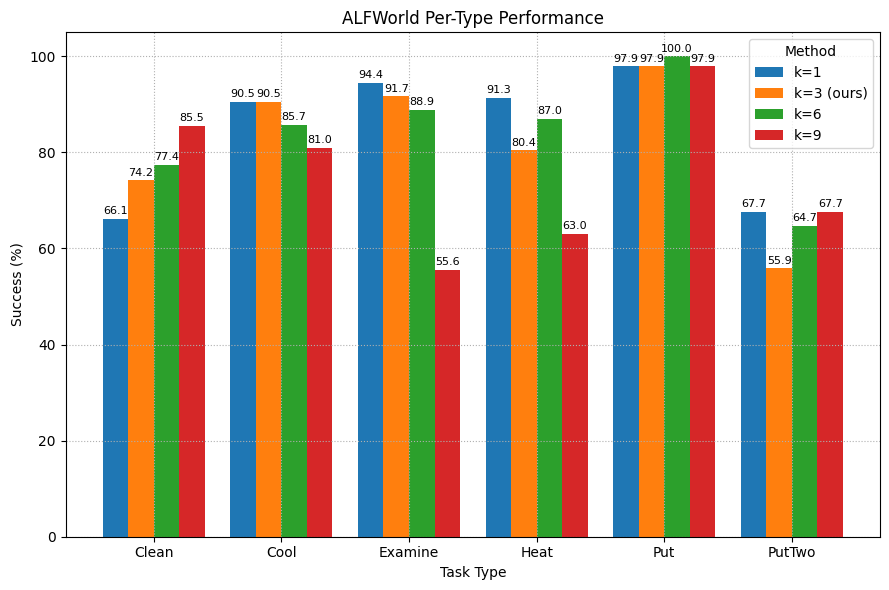

In [158]:
import matplotlib.pyplot as plt
import numpy as np


# Data from your LaTeX table
categories = ["Clean", "Cool", "Examine", "Heat", "Put", "PutTwo"]
k1 = [66.13, 90.48, 94.44, 91.30, 97.92, 67.65]
k3 = [74.19, 90.48, 91.67, 80.43, 97.92, 55.88]
k6 = [77.42, 85.71, 88.89, 86.96, 100.00, 64.71]
k9 = [85.48, 80.95, 55.56, 63.04, 97.92, 67.65]

methods = {
    "k=1": k1,
    "k=3 (ours)": k3,
    "k=6": k6,
    "k=9": k9,
}

color_map = {
    "k=1": "tab:blue",
    "k=3 (ours)": "tab:orange",
    "k=6": "tab:green",
    "k=9": "tab:red",
}


# base =     [82.26, 80.95, 75.00, 78.26, 95.83, 58.82]
# rag =      [74.19, 90.48, 91.67, 80.43, 97.92, 55.88]
# ft =       [90.32, 85.71, 88.89, 91.30, 95.83, 50.00]
# ft_rag =   [96.77, 95.24, 83.33, 97.83, 97.92, 64.71]

# methods = {
#     "Base": base,
#     "RAG": rag,
#     "SFT": ft,
#     "Distillation": ft_rag,
# }

# color_map = {
#     "Base": "tab:blue",
#     "RAG": "tab:orange",
#     "SFT": "tab:green",
#     "Distillation": "tab:red",
# }


# Plot config
x = np.arange(len(categories))  # positions
width = 0.2                     # bar width

fig, ax = plt.subplots(figsize=(9, 6))
ax.grid(True, linestyle=":", linewidth=0.8)

# Plot each method as a group
for i, (method, values) in enumerate(methods.items()):
    ax.bar(
        x + i*width - 1.5*width,  # center the groups
        values,
        width,
        label=method.replace("_", "+"),
        color=color_map[method]
    )

# Labels and style
ax.set_ylabel("Success (%)")
ax.set_xlabel("Task Type")
ax.set_title("ALFWorld Per-Type Performance")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 105)  # give headroom above 100
ax.legend(title="Method")

# Annotate bar values
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.1f", padding=2, fontsize=8)

plt.tight_layout()
plt.savefig("alfworld_pertype_bar.png", dpi=400)
plt.show()


## Analysis

In [13]:
# file_name = "state_rag_selfgenerated_tagged" #83.58
# file_name = "react_rag_selfgenerated_tagged" #86.57
# file_name = "state_rag_selfgenerated_ft_state_tagged" #83.58
# file_name = "react_rag_selfgenerated_ft_react_tagged" #88.81


# file_name = "state_rag_selfgenerated" #85.07 #Beat 24 fails
# file_name = "react_rag_selfgenerated" #88.81 #Beat 30/29 fails
# file_name = "react_rag_selfgenerated_reacthints" #79.10

# file_name = "state_rag_selfgenerated_ft_state" #79.85
# file_name = "react_rag_selfgenerated_ft_react" #82.84

# file_name = "state_rag_selfgenerated_train" #84.17
# file_name = "react_rag_selfgenerated_train" #74.58

# file_name = "baseline_state_train_all_logged" #73.00
# file_name = "baseline_react_train_all" #61.17
# file_name = "react_rag_selfgenerated_train_reacthints" #79.83

# file_name = "react_rag_selfgenerated_train"
# file_name = "state_rag_selfgenerated_train"

print_results(file_name)

new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
# print(df.to_markdown(index=False))
y

['react']
['Qwen/Qwen2.5-14B-Instruct']

Results for react_rag_selfgenerated_train
For Model: Qwen/Qwen2.5-14B-Instruct

For Agent: react
Success: 74.58
Avg. Steps: 22.76
Avg. Tokens: 1543114
Successes: 895, Fails: 305
   Agent     Task Success
0  react    Clean  66.94%
1  react     Cool  85.53%
2  react  Examine  88.46%
3  react     Heat  57.89%
4  react      Put  92.64%
5  react   Puttwo  62.37%


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,667.910448,895,305,20.256983,30.118033,22.763333,1.543114e+06,67789.471409,2390.7175,0.004833


In [72]:
file_name = "state_selfgenerated_ft_state_rag" #89.55, 13.99, 52k
# file_name = "react_selfgenerated_ft_react_rag" #92.54, 19.37, 38k 
# file_name = "state_rag_selfgenerated_ft_state_rag" #90.30, 13.82, 51k
# file_name = "react_rag_selfgenerated_ft_react_rag" #93.28, 18.75, 39k

# file_name = "stateact_ft_react" #71.64
# file_name = "react_ft_react" #86.57, 25.39

# file_name = "stateact_rag_ft_react" #
# file_name = "react_rag_ft_react" #82.09
# file_name = "react_ft_react_rag" #82.09


# file_name = "14B_state_rag_1hint" #86.57
# file_name = "state_rag_selfgenerated" #85.07, 15.20
# file_name = "14B_state_rag_6hint" #86.57
# file_name = "14B_state_rag_9hint" #75.37, 18.00

# file_name = "14B_react_rag_1hint" #81.34
# file_name = "react_rag_selfgenerated" #88.81, 22.17
# file_name = "14B_react_rag_6hint" #82.09
# file_name = "14B_react_rag_9hint" #78.36

file_name = "react_rag_bm25" #79.85
file_name = "react_rag_tfidf" #79.85

# file_path=os.path.join("final_game_logs",f"alfworld_eval_{file_name}","alfworld_results.csv")
file_path = None

print_results(file_name, file_path)

new_eval = load_data(file_name, file_path)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
# print(df.to_markdown(index=False))
y

['react']
['Qwen/Qwen2.5-14B-Instruct']

Results for react_rag_tfidf
For Model: Qwen/Qwen2.5-14B-Instruct

For Agent: react
Success: 77.27
Avg. Steps: 19.88
Avg. Tokens: 42402
Successes: 51, Fails: 15
   Agent     Task  Success
0  react    Clean   41.18%
1  react     Cool   77.78%
2  react  Examine  100.00%
3  react     Heat  100.00%
4  react      Put  100.00%
5  react   Puttwo   57.14%


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,38.059701,51,15,18.980392,22.933333,19.878788,42402.151515,2133.035061,2307.30303,0.182238


In [7]:
# file_name = "baseline_state_train_all" #73.17
# file_name = "baseline_state_gpt4o_train_all" #80.5
# file_name = "baseline_expel_train_all" #72.67

# file_name = "baseline_state_prompt_dividers" #82.96

# file_name = "hints_diffprompt" #75.56
# file_name = "hints_gold_fix" #75.56
# file_name = "hints_gold_ontop" #79.26

file_name = "hints_gold_gpt4o" #85.82, 13.67

# file_name = "stateact_ft_gold_1epoch_nofewshot_nobadsteps_lowlr_fixed" #82.96
# file_name = "hints_ft_gold_1epoch_nofewshot_nobadsteps_lowlr" #85.93

# file_name = "react_hints_ft_gold_1epoch_nofewshot_nobadsteps_lowlr" #90.37
# file_name = "react_ft_gold_1epoch_nofewshot_nobadsteps_lowlr" # 87.41


file_name = "react_vanilla_ft_vanilla_all" #72.39

# file_name = "state_hints_ft_vanilla_handpicked" #87.41
# file_name = "react_hints_ft_vanilla_all" #89.63??????

new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
print(df.to_markdown(index=False))
y

| Model                     | Task    | Success   |
|:--------------------------|:--------|:----------|
| Qwen/Qwen2.5-14B-Instruct | Clean   | 80.65%    |
| Qwen/Qwen2.5-14B-Instruct | Cool    | 100.00%   |
| Qwen/Qwen2.5-14B-Instruct | Examine | 50.00%    |
| Qwen/Qwen2.5-14B-Instruct | Heat    | 69.57%    |
| Qwen/Qwen2.5-14B-Instruct | Put     | 75.00%    |
| Qwen/Qwen2.5-14B-Instruct | Puttwo  | 47.06%    |


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,72.38806,97,37,18.329897,23.567568,19.776119,40931.955224,2069.766792,2291.477612,0.17685


In [58]:

# file_name = "state_hints_ft_rag_20handpicked_lorareg" #93.28
file_name = "state_vanilla_ft_rag_20handpicked_lorareg" #90.30

# file_name = "state_hints_ft_rag_all_lorareg" #90.30
# file_name = "state_vanilla_ft_rag_all_lorareg" #85.07


new_eval = load_data(file_name)
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
print(df.to_markdown(index=False))
y

| Model     | Task    | Success   |
|:----------|:--------|:----------|
| ours-text | Clean   | 93.55%    |
| ours-text | Cool    | 95.24%    |
| ours-text | Examine | 83.33%    |
| ours-text | Heat    | 100.00%   |
| ours-text | Put     | 100.00%   |
| ours-text | Puttwo  | 58.82%    |


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,90.298507,121,13,NaN,NaN,NaN,7159072,3703.606829,4105.641791,0.169016


In [8]:
# file_name = "stateact_ft_react" #71.64
file_name = "react_ft_react" #86.57

# file_name = "stateact_rag_ft_react" #
file_name = "react_rag_ft_react" #82.09


# new_eval = load_data(file_name)
new_eval = pd.read_csv("game_logs_ftreact/alfworld_eval_"+file_name+"/alfworld_results.csv")
# new_eval.head()

x,y,df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

# x.head(15)
print(df.to_markdown(index=False))
y

| Model                     | Task    | Success   |
|:--------------------------|:--------|:----------|
| Qwen/Qwen2.5-14B-Instruct | Clean   | 90.32%    |
| Qwen/Qwen2.5-14B-Instruct | Cool    | 76.19%    |
| Qwen/Qwen2.5-14B-Instruct | Examine | 94.44%    |
| Qwen/Qwen2.5-14B-Instruct | Heat    | 86.96%    |
| Qwen/Qwen2.5-14B-Instruct | Put     | 95.83%    |
| Qwen/Qwen2.5-14B-Instruct | Puttwo  | 70.59%    |


,model,prompt_name,correction,success_percentage,success,failures,avg_success_steps,avg_fail_steps,avg_steps,total_io_tokens,tokens_per_step,avg_history_token,efficiency_success_per_10k_tok
0,Qwen/Qwen2.5-14B-Instruct,react-1_0,True,86.567164,116,18,23.172414,39.666667,25.38806,54983.335821,2165.716343,2472.91791,0.157443


In [ ]:
#7B LAND

# file_name = "baseline_7B" #42.54 state, DO NOT USE
# file_name = "baseline_7B_rag" #63.43 react, 65.67 state
# file_name = "7B_react_rag_self" #73.13
file_name = "7B_state_rag_self" #69.40

# file_name = "7B_react_vanilla_ft_vanilla_all" #11.19
# file_name = "7B_react_vanilla_ft_vanilla_20handpicked" #49.25

# file_name = "7B_state_vanilla_ft_vanilla_all" #75.37
# file_name = "7B_state_vanilla_ft_vanilla_20handpicked" #62.69

# file_name = "7B_react_vanilla_ft_rag_all" #33.58
file_name = "7B_react_vanilla_ft_rag_all_self" #68.66
# file_name = "7B_react_vanilla_ft_rag_20handpicked" #53.73

# file_name = "7B_react_rag_ft_vanilla_all" #40.30
file_name = "7B_react_rag_ft_vanilla_all_self" #42.54
# file_name = "7B_react_rag_ft_vanilla_20handpicked" #61.94

# file_name = "7B_state_rag_ft_vanilla_all" #81.34
file_name = "7B_state_rag_ft_vanilla_all_self" #84.33
# file_name = "7B_state_rag_ft_vanilla_20handpicked" #76.12

# file_name = "7B_state_vanilla_ft_rag_all" #82.09
file_name = "7B_state_vanilla_ft_rag_all_self" #
# file_name = "7B_state_vanilla_ft_rag_20handpicked" #60.45

# file_name = "7B_react_rag_ft_rag_all" #58.21
file_name = "7B_react_rag_ft_rag_all_self" #58.21
# file_name = "7B_react_rag_ft_rag_20handpicked" #71.64

# file_name = "7B_state_rag_ft_rag_all" #88.06
# file_name = "7B_state_rag_ft_rag_20handpicked" #74.63

print_results(file_name)

new_eval = load_data(file_name)
# new_eval.head()

x,y, df = analyse_data(new_eval)

# y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')


# print(df.to_markdown(index=False))
# x.head(15)
y

In [87]:
for prompt_name in new_eval.prompt_name.unique():
    a = new_eval[new_eval.prompt_name == prompt_name].num_of_steps.mean()
    print(prompt_name, a)

react-1_0 28.134328358208954
stringstate-1_0-k-goal+locations_visited+current_location+current_inventory+thought+action 18.402985074626866


In [175]:
# !/usr/bin/env python
# aggregate_hints_by_type.py
import argparse, json, pathlib, re
from collections import defaultdict, Counter


def title_type(t: str) -> str:
    return t.replace("-", " ").title()

def aggregate(in_path: str,
              top_k_triggers: int = 3,
              top_k_fixes: int = 3,
              max_env_types: int = 6):
    # type -> Counter(text -> count)
    counts = defaultdict(Counter)
    triggers = defaultdict(lambda: defaultdict(Counter))   # [type][text] -> Counter(trigger)
    fixes = defaultdict(lambda: defaultdict(Counter))      # [type][text] -> Counter(fix)
    envtypes = defaultdict(lambda: defaultdict(Counter))   # [type][text] -> Counter(env_type)
    # raise ValueError
                  
    n_lines = 0
    with open(in_path) as f:
        for line in f:
            n_lines += 1
            try:
                rec = json.loads(line)
            except Exception:
                continue

            env_type = str(rec.get("env_type","unknown"))
            # print(env_type)
            for h in rec.get("hints", []) or []:
                # t = normalize_type(h.get("type",""))
                t = env_type
                txt = (h.get("text") or "").strip()
                if not txt:
                    continue
                counts[t][txt] += 1
                # trig = (h.get("when_to_trigger") or "").strip()
                # fix  = (h.get("example_fix") or "").strip()
                # if trig:
                #     triggers[t][txt][trig] += 1
                # if fix:
                #     fixes[t][txt][fix] += 1
                if env_type:
                    envtypes[t][txt][env_type] += 1

    # Build output
    sections = {}
    types_sorted = [t for t in CANON_ORDER if t in counts] + sorted(
        [t for t in counts.keys() if t not in CANON_ORDER]
    )
    for t in types_sorted:
        items = []
        for text, c in counts[t].most_common():
            # top_trigs = [k for k,_ in triggers[t][text].most_common(top_k_triggers)]
            # top_fix   = [k for k,_ in fixes[t][text].most_common(top_k_fixes)]
            top_envs  = dict(envtypes[t][text].most_common(max_env_types))
            # items.append({
            #     "text": text,
            #     "count": c,
            #     # "top_triggers": top_trigs,
            #     # "top_example_fixes": top_fix,
            #     # "env_types": top_envs,
            # })
            items.append(text)
            
        sub_section = {}
        # sub_section[title_type(t)] = {}
        sub_section = {
            "total_unique_hints": len(items),
            "total_mentions": sum(counts[t].values()),
            "hints": items
        }
        sections[title_type(t).lower()] = {}
        sections[title_type(t).lower()] = sub_section
        # sections.append(sub_section)
        # sections.append({
        #     "type": title_type(t),
        #     "total_unique_hints": len(items),
        #     "total_mentions": sum(counts[t].values()),
        #     "hints": items
        # })
    return sections
    # return {
    #     # "summary": {
    #     #     "files_processed": 1,
    #     #     "lines_read": n_lines,
    #     #     "total_types": len(sections),
    #     #     "total_unique_hints": sum(len(s["hints"]) for s in sections),
    #     #     "total_mentions": sum(s["total_mentions"] for s in sections),
    #     # },
    #     "by_type": sections
    # }


inp = "/workspace/stateact-ft/alfworld_runs/game_logs/hints_GPT4o.ndjson"
out = "/workspace/stateact-ft/alfworld_runs/game_logs/hints_by_type_GPT4o.json"
report = aggregate(inp, 3, 3, 6)
pathlib.Path(out).parent.mkdir(parents=True, exist_ok=True)
with open(out, "w") as f:
    json.dump(report, f, indent=2)
print(f"[OK] wrote → {out}")



[OK] wrote → /workspace/stateact-ft/alfworld_runs/game_logs/hints_by_type_GPT4o.json


In [103]:
file_name = "baseline_state"

# new_eval = load_data("v4_0_0_eval")
new_eval = load_data(file_name)
# new_eval.head()

x,y = analyse_data_old(new_eval)
y.to_csv(f"{file_name}_scores.csv",sep="&",index=False, float_format='%.2f')

x.head(15)

,model,prompt_name,correction,env_idx,success,done,early_stop,error,num_of_steps,success_percentage
0,Qwen/Qwen2.5-14B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,8911,110,111,23,0,1968,81.481481
1,Qwen/Qwen2.5-7B-Instruct,stringstate-1_0-k-goal+locations_visited+curre...,True,8911,60,64,70,0,2275,44.444444


In [53]:
from scipy.stats import pearsonr, spearmanr, ks_2samp
import pandas as pd

def compute_correlation_with_significance(df, col1, col2):
    df = df[[col1, col2]].dropna()
    pearson_corr, pearson_p = pearsonr(df[col1], df[col2])
    spearman_corr, spearman_p = spearmanr(df[col1], df[col2])
    return {
        "pearson_correlation": pearson_corr,
        "pearson_p_value": pearson_p,
        "spearman_correlation": spearman_corr,
        "spearman_p_value": spearman_p
    }

def compare_distributions_ks(comparison_df, col1, col2):
    df = comparison_df[[col1, col2]].dropna()
    ks_stat, p_value = ks_2samp(df[col1], df[col2])
    return {
        "ks_statistic": ks_stat,
        "p_value": p_value
    }

def analyze_success_overlap(file1: str, file2: str, name1="file1", name2="file2"):
    # Load files
    df1 = pd.read_json(file1) if file1.endswith(".json") else pd.read_csv(file1)
    df2 = pd.read_json(file2) if file2.endswith(".json") else pd.read_csv(file2)

    # Filter for consistent model
    df1 = df1[df1["model"] == "Qwen/Qwen2.5-14B-Instruct"]
    df2 = df2[df2["model"] == "Qwen/Qwen2.5-14B-Instruct"]

    # Select relevant columns
    df1 = df1[["env_idx", "success", "env_type"]].rename(columns={"success": f"{name1}_success"})
    df2 = df2[["env_idx", "success", "env_type"]].rename(columns={"success": f"{name2}_success"})

    # Merge
    merged = pd.merge(df1, df2, on="env_idx", how="inner")

    # Compute overlap categories
    result_types = []
    for _, row in merged.iterrows():
        a = row[f"{name1}_success"]
        b = row[f"{name2}_success"]
        if a and b:
            result = "Both Successful"
        elif not a and not b:
            result = "Both Failed"
        elif a and not b:
            result = f"Only {name1} Successful"
        else:
            result = f"Only {name2} Successful"
        result_types.append(result)

    merged["result_type"] = result_types

    # Overall result summary
    summary = merged["result_type"].value_counts().reset_index()
    summary.columns = ["Outcome", "Count"]

    # Per-task outcome distribution
    summary_by_category = {}
    for env_type in merged["env_type_x"].unique():
        temp = merged[merged["env_type_x"] == env_type]
        counts = temp["result_type"].value_counts().reset_index()
        counts.columns = ["Outcome", "Count"]
        summary_by_category[env_type] = counts

    # Per-task success rate table
    success_table = []
    for task in sorted(merged["env_type_x"].unique()):
        sub = merged[merged["env_type_x"] == task]
        total = len(sub)
        baseline_success = sub[f"{name1}_success"].sum() / total * 100
        hint_success     = sub[f"{name2}_success"].sum() / total * 100
        success_table.append({
            "Task": task.capitalize(),
            f"{name1} Success": f"{baseline_success:.2f}%",
            f"{name2} Success": f"{hint_success:.2f}%"
        })

    success_df = pd.DataFrame(success_table)

    return summary, merged, summary_by_category, success_df


In [78]:
trial_num = 4
a = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_sanity_check_fixed/alfworld_results.csv"
# b = f"/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_expel_trial{trial_num}_retrieve_llm/alfworld_results.csv"
# a = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetuned/alfworld_results.csv"
# b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetuned_2/alfworld_results.csv"
# b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetunedonhints/alfworld_results.csv"
# b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_baseline_stateact_finetuned_bigmodel/alfworld_results.csv"
b = "/rds/general/user/hai24/home/StateAct/alfworld_runs/game_logs/alfworld_eval_stateact_ft_full_hard_abovemean/alfworld_results.csv"



# df = analyse_data_compare(a, b)
# df = compare_success_per_env_idx(a, b, "baseline", "trial4")
# corr = compute_correlation_with_significance(df, "baseline", "trial4")
summary, merged, summary_by_category, task_success_df = analyze_success_overlap(a, b, "Baseline", f"Hard FT")
# summary, merged, summary_by_category, task_success_df = analyze_success_overlap(a, b, "FT", f"FT on FT traces")
# df.to_csv("a.csv")
print(summary.to_string(index=False), "\n")

print(task_success_df.to_string(index=False))

for key, value in summary_by_category.items():
    print()
    print("For task type:", key)
    print(value.to_string(index=False))
# print(summary_by_category)

                 Outcome  Count
         Both Successful     97
 Only Hard FT Successful     19
Only Baseline Successful     13
             Both Failed      5 

   Task Baseline Success Hard FT Success
  Clean           87.10%          96.77%
   Cool           95.24%          85.71%
Examine           72.22%          66.67%
   Heat           86.96%         100.00%
    Put           91.67%         100.00%
 Puttwo           47.06%          52.94%

For task type: clean
                 Outcome  Count
         Both Successful     26
 Only Hard FT Successful      4
Only Baseline Successful      1

For task type: cool
                 Outcome  Count
         Both Successful     17
Only Baseline Successful      3
 Only Hard FT Successful      1

For task type: examine
                 Outcome  Count
         Both Successful      9
Only Baseline Successful      4
 Only Hard FT Successful      3
             Both Failed      2

For task type: put
                Outcome  Count
        Both Succ

In [28]:
merged[merged["result_type"]=="Both Failed"]

,env_idx,baseline_success,env_type_x,trial4_success,env_type_y,result_type
24,24,False,puttwo,False,puttwo,Both Failed
41,41,False,puttwo,False,puttwo,Both Failed
48,48,False,examine,False,examine,Both Failed
61,61,False,puttwo,False,puttwo,Both Failed
70,70,False,examine,False,examine,Both Failed
98,98,False,examine,False,examine,Both Failed
99,99,False,clean,False,clean,Both Failed
116,116,False,puttwo,False,puttwo,Both Failed


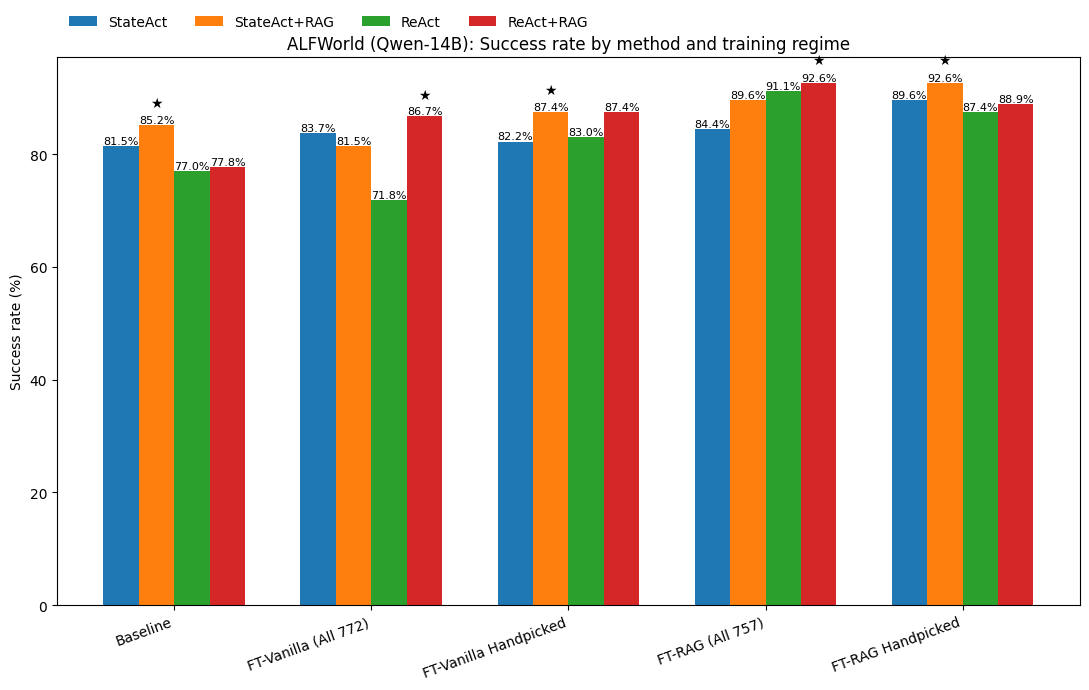

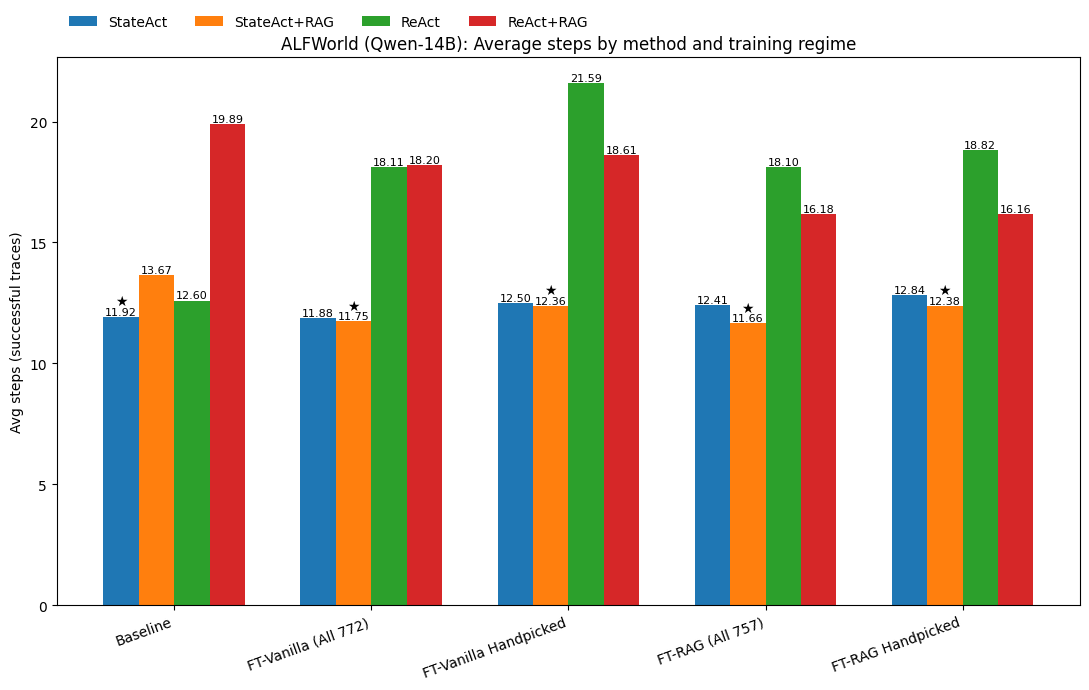

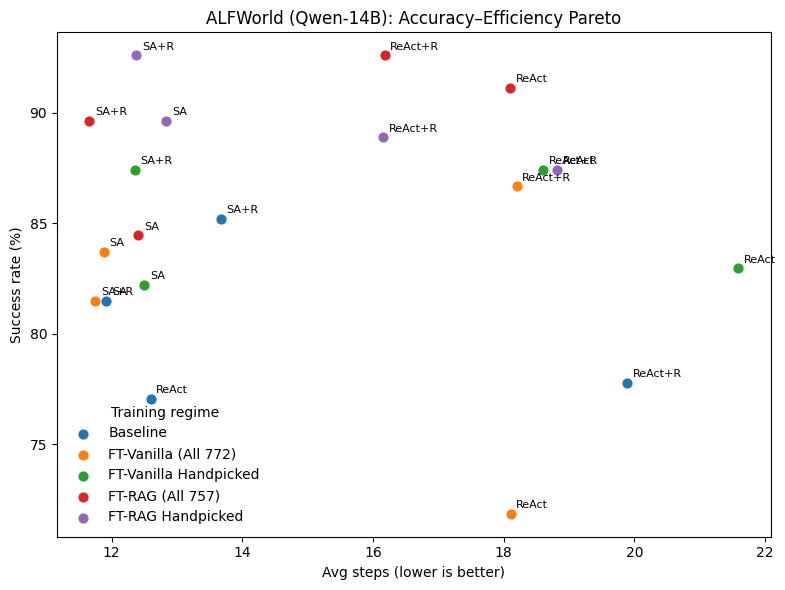

In [9]:
# Create tidy DataFrame and generate example plots (matplotlib only, no custom colors)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- Data ----------------------
methods = ["StateAct", "StateAct+RAG", "ReAct", "ReAct+RAG"]
regimes = [
    ("baseline",        0,   "Baseline"),
    ("ft_vanilla_all",  772, "FT-Vanilla (All 772)"),
    ("ft_vanilla_20",   120, "FT-Vanilla Handpicked"),
    ("ft_rag_all",      757, "FT-RAG (All 757)"),
    ("ft_rag_20",       120, "FT-RAG Handpicked"),
]

success = {
  "baseline":        [81.48, 85.19, 77.04, 77.78],
  "ft_vanilla_all":  [83.70, 81.48, 71.85, 86.67],
  "ft_vanilla_20":   [82.22, 87.41, 82.96, 87.41],
  "ft_rag_all":      [84.44, 89.63, 91.11, 92.59],
  "ft_rag_20":       [89.63, 92.59, 87.41, 88.89],
}
steps = {
  "baseline":        [11.92, 13.67, 12.60, 19.89],
  "ft_vanilla_all":  [11.88, 11.75, 18.11, 18.20],
  "ft_vanilla_20":   [12.50, 12.36, 21.59, 18.61],
  "ft_rag_all":      [12.41, 11.66, 18.10, 16.18],
  "ft_rag_20":       [12.84, 12.38, 18.82, 16.16],
}

rows = []
for key, n, label in regimes:
    for i, m in enumerate(methods):
        rows.append({
            "env": "ALFWorld",
            "backbone": "Qwen-14B",
            "method": m,
            "training_regime": key,
            "regime_label": label,
            "n_examples": n,
            "success_rate_pct": success[key][i],
            "avg_steps": steps[key][i],
        })
df = pd.DataFrame(rows)

# ---------------------- Helper: grouped bar plot ----------------------
def grouped_bar(df, value_col, ylabel, title, filename, annotate_pct=False, lower_is_better=False):
    x_labels = [r[2] for r in regimes]
    x = np.arange(len(x_labels))
    width = 0.18  # bar width
    fig = plt.figure(figsize=(11, 7))  # single-plot figure (no subplots)

    # compute best per regime for annotation
    best_indices = {}
    for i, (reg_key, _, _) in enumerate(regimes):
        sub = df[df["training_regime"] == reg_key]
        if lower_is_better:
            idx = sub[value_col].values.argmin()
        else:
            idx = sub[value_col].values.argmax()
        best_indices[reg_key] = idx  # index *within* order of methods

    # plot each method as its own series
    for j, method in enumerate(methods):
        vals = [df[(df["method"] == method) & (df["training_regime"] == rk)][value_col].values[0]
                for rk, _, _ in regimes]
        bars = plt.bar(x + (j-1.5)*width, vals, width, label=method)
        # annotate each bar
        for i_bar, b in enumerate(bars):
            v = b.get_height()
            if annotate_pct:
                label = f"{v:.1f}%"
            else:
                label = f"{v:.2f}"
            plt.text(b.get_x() + b.get_width()/2, v, label, ha='center', va='bottom', fontsize=8, rotation=0)
        # add asterisk to the best per regime
        for i_reg, (reg_key, _, _) in enumerate(regimes):
            if best_indices[reg_key] == j:
                bx = x[i_reg] + (j-1.5)*width
                bv = vals[i_reg]
                plt.text(bx, bv*1.03, "★", ha='center', va='bottom', fontsize=10)

    plt.xticks(x, x_labels, rotation=20, ha='right')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(0,1.1))
    plt.tight_layout()
    # plt.savefig(f"/mnt/data/{filename}", dpi=200)
    plt.show()

# ---------------------- Plot 1: Success rate ----------------------
grouped_bar(
    df=df,
    value_col="success_rate_pct",
    ylabel="Success rate (%)",
    title="ALFWorld (Qwen-14B): Success rate by method and training regime",
    filename="success_rates_grouped.png",
    annotate_pct=True,
    lower_is_better=False
)

# ---------------------- Plot 2: Avg steps ----------------------
grouped_bar(
    df=df,
    value_col="avg_steps",
    ylabel="Avg steps (successful traces)",
    title="ALFWorld (Qwen-14B): Average steps by method and training regime",
    filename="avg_steps_grouped.png",
    annotate_pct=False,
    lower_is_better=True
)

# ---------------------- Plot 3: Pareto (success vs steps) ----------------------
fig = plt.figure(figsize=(8, 6))
for (rk, n, label) in regimes:
    sub = df[df["training_regime"] == rk]
    x = sub["avg_steps"].values
    y = sub["success_rate_pct"].values
    plt.scatter(x, y, s=40, label=label)

# annotate short tags
tag_map = {"StateAct":"SA", "StateAct+RAG":"SA+R", "ReAct":"ReAct", "ReAct+RAG":"ReAct+R"}
for _, row in df.iterrows():
    tag = f'{tag_map[row["method"]]}'
    plt.annotate(tag, (row["avg_steps"], row["success_rate_pct"]), textcoords="offset points", xytext=(4,4), fontsize=8)

plt.xlabel("Avg steps (lower is better)")
plt.ylabel("Success rate (%)")
plt.title("ALFWorld (Qwen-14B): Accuracy–Efficiency Pareto")
plt.legend(frameon=False, title="Training regime")
plt.tight_layout()
# plt.savefig("/mnt/data/pareto_success_vs_steps.png", dpi=200)
plt.show()

# Provide file paths for download
# print("Saved figures to:")
# print("/mnt/data/success_rates_grouped.png")
# print("/mnt/data/avg_steps_grouped.png")
# print("/mnt/data/pareto_success_vs_steps.png")
